# Model training with custom network

In [ ]:
import json
import torch
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image
import numpy as np
from collections import defaultdict
import sys

# --- Configuration ---
# PLEASE VERIFY these paths match your Config class
IMAGE_DIR = '/content/drive/MyDrive/assets/images'
ANNOTATIONS_FILE = '/content/drive/MyDrive/annotations2.coco.json'

class FloorplanDataset(Dataset):
    """Custom dataset for floorplan room detection"""

    def __init__(self, image_dir, annotations_file):
        self.image_dir = Path(image_dir)

        with open(annotations_file, 'r') as f:
            self.data = json.load(f)

        self.images = self.data.get('images', [])
        self.annotations = self.data.get('annotations', [])

        # Build annotation lookup
        self.annotations_by_image = defaultdict(list)
        for ann in self.annotations:
            self.annotations_by_image[ann['image_id']].append(ann)

    @staticmethod
    def assign_room_label(area):
        """Assign room label based on bounding box area"""
        if area > 3000:
            return "bedroom"
        elif area > 1500:
            return "kitchen"
        elif area > 1000:
            return "bathroom"
        elif area > 500:
            return "garage"
        else:
            return "hall"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # We only care about the targets, so we'll skip image loading
        # to make this script run much faster.
        image_info = self.images[idx]
        image_id = image_info['id']
        file_name = image_info['file_name'] # For logging

        # Extract room counts
        annotations = self.annotations_by_image.get(image_id, [])
        room_counts = defaultdict(int)

        for ann in annotations:
            if ann['category_id'] in [0, 5]:
                room_label = self.assign_room_label(ann['area'])
                room_counts[room_label] += 1

        targets = {
            'bedroom': int(room_counts['bedroom']),
            'kitchen': int(room_counts['kitchen']),
            'bathroom': int(room_counts['bathroom']),
            'garage': int(room_counts['garage']),
            'hall': int(room_counts['hall']),
            'total_rooms': int(sum(room_counts.values()))
        }

        # Return file_name as well for easy debugging
        return {'targets': targets, 'file_name': file_name}

# --- Main execution ---
print("Checking dataset for max room counts...")

try:
    # 1. Load dataset
    dataset = FloorplanDataset(IMAGE_DIR, ANNOTATIONS_FILE)
    print(f"✓ Loaded {len(dataset)} annotations.")

    # 2. Initialize trackers
    max_counts = defaultdict(int)
    # To store which file has the max count
    max_count_files = defaultdict(str)

    # 3. Iterate and check every item
    for i in range(len(dataset)):
        
        try:
            data_item = dataset[i]
            targets = data_item['targets']
            file_name = data_item['file_name']

            for room_type, count in targets.items():
                if count > max_counts[room_type]:
                    max_counts[room_type] = count
                    max_count_files[room_type] = file_name

        except Exception as e:
            print(f"Error processing item {i}: {e}")

        # Print progress
        if (i + 1) % 200 == 0:
            print(f"  ... processed {i+1}/{len(dataset)} items")

    # 4. Print results
    print("\n" + "="*50)
    print("✓ Dataset Check Complete")
    print("Maximum counts found for each category:")
    print("="*50)

    for room_type, count in max_counts.items():
        print(f"  • {room_type.upper():12}: {count}")
        print(f"    (Found in file: {max_count_files[room_type]})")

    print("\n--- Recommended Config ---")
    max_per_type = 0
    for room_type in ['bedroom', 'kitchen', 'bathroom', 'garage', 'hall']:
        if max_counts[room_type] > max_per_type:
            max_per_type = max_counts[room_type]

    print(f"To fix the error, your 'max_rooms_per_type' in Config")
    print(f"must be AT LEAST: {max_per_type + 1}")

    total_rooms_output_size = max_counts['total_rooms'] + 1
    print(f"Your 'total_rooms_head' output size should be AT LEAST: {total_rooms_output_size}")
    print(f"(Current size: {10 * 2} = 20)")

    if total_rooms_output_size > ( (max_per_type + 1) * 2 ):
         print("\nWARNING: Your max 'total_rooms' is larger than expected.")
         print("You may need to increase 'max_rooms_per_type' even further")
         print(f"just to make the 'total_rooms_head' large enough.")


except FileNotFoundError:
    print("\n" + "!"*50)
    print("ERROR: Could not find the annotation file.")
    print(f"Make sure this path is correct: {ANNOTATIONS_FILE}")
    print("And that your Google Drive is mounted!")
    print("!"*50)
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

Checking dataset for max room counts...
✓ Loaded 545 annotations.
  ... processed 200/545 items
  ... processed 400/545 items

✓ Dataset Check Complete
Maximum counts found for each category:
  • BEDROOM     : 7
    (Found in file: 14_19_jpg.rf.2f607c5ebe2225eb7e1df18c39cc12ba.jpg)
  • KITCHEN     : 14
    (Found in file: 15_28_jpg.rf.6328bf1b896ade84d3edbf57d6a77959.jpg)
  • BATHROOM    : 10
    (Found in file: 17_21_jpg.rf.5407d3e3248bd44b2154d52ec9087811.jpg)
  • GARAGE      : 20
    (Found in file: 15_28_jpg.rf.e50251da05fd2a14abcfc2e5e8be8ebc.jpg)
  • HALL        : 23
    (Found in file: 10_17_jpg.rf.9375b3b0c08b91102b161b15394f6106.jpg)
  • TOTAL_ROOMS : 40
    (Found in file: 15_28_jpg.rf.6328bf1b896ade84d3edbf57d6a77959.jpg)

--- Recommended Config ---
To fix the error, your 'max_rooms_per_type' in Config
must be AT LEAST: 24
Your 'total_rooms_head' output size should be AT LEAST: 41
(Current size: 20 = 20)


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

FLOORPLAN ROOM DETECTION - TRAINING PIPELINE

 Using device: CUDA

1. Loading dataset...
   Loaded 545 images
    Train: 436, Val: 54, Test: 55
    Split ratio: 80% / 10% / 10%

2. Initializing model...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

    Model created with 11,350,534 parameters

3. Training model...
--------------------------------------------------------------------------------
Epoch   1/50 | Train Loss: 14.0742 | Val Loss: 14.3765
Epoch   2/50 | Train Loss: 11.9877 | Val Loss: 26.8075
Epoch   3/50 | Train Loss: 11.0753 | Val Loss: 13.4172
Epoch   4/50 | Train Loss: 10.3246 | Val Loss: 10.9605
Epoch   5/50 | Train Loss: 9.5485 | Val Loss: 11.9493
Epoch   6/50 | Train Loss: 9.1464 | Val Loss: 11.0327
Epoch   7/50 | Train Loss: 8.6503 | Val Loss: 11.2780
Epoch   8/50 | Train Loss: 8.2660 | Val Loss: 11.8788
Epoch   9/50 | Train Loss: 7.9916 | Val Loss: 12.5706
Epoch  10/50 | Train Loss: 7.7906 | Val Loss: 10.6001
           Saved checkpoints/checkpoint_epoch_10.pth
Epoch  11/50 | Train Loss: 7.6248 | Val Loss: 8.8136
Epoch  12/50 | Train Loss: 7.5314 | Val Loss: 8.8412
Epoch  13/50 | Train Loss: 7.3074 | Val Loss: 10.1917
Epoch  14/50 | Train Loss: 6.8888 | Val Loss: 8.6412
Epoch  15/50 | Train Loss: 6.6578 | Val Lo

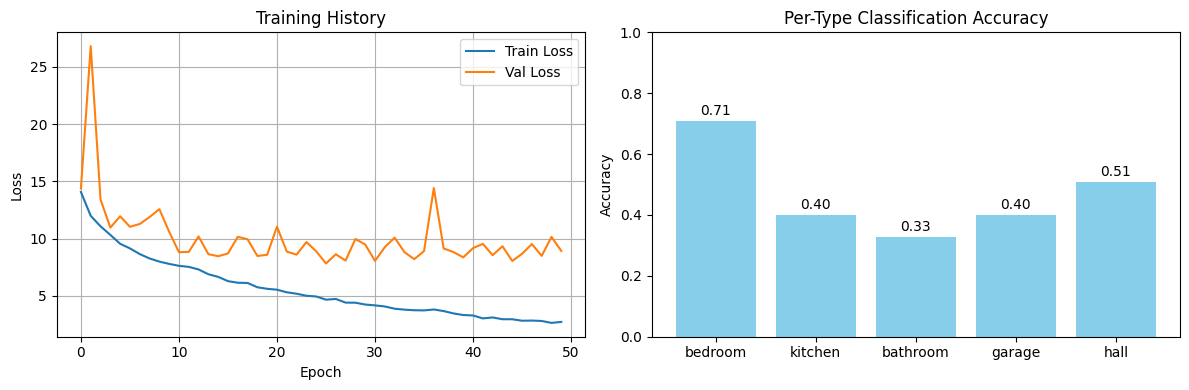

In [ ]:

"""
Floorplan Room Detection - Training Notebook (Python Script Format)
Complete training pipeline with metrics and evaluation
"""

import json
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset
from pathlib import Path
from PIL import Image
import numpy as np
from collections import defaultdict
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# ============================================================================
# 1. CONFIGURATION
# ============================================================================

class Config:
    """Training configuration"""
    # Data
    image_dir = '/content/drive/MyDrive/assets/train'
    annotations_file = '/content/drive/MyDrive/annotations2.coco.json'
    max_rooms_per_type = 24

    # Training
    batch_size = 32
    num_epochs = 50
    learning_rate = 1e-3
    weight_decay = 1e-4

    # Model
    max_rooms_per_type = 10

    # Device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Output
    checkpoint_dir = 'checkpoints'
    output_predictions = 'floorplan_predictions.json'
    metrics_file = 'metrics.json'


# ============================================================================
# 2. MODEL ARCHITECTURE
# ============================================================================

class RoomDetectionCNN(nn.Module):
    """CNN for room detection in floorplans"""

    def __init__(self, max_rooms_per_type=10):
        super().__init__()

        # Backbone: ResNet-18 pretrained on ImageNet
        self.backbone = torchvision.models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()

        # Shared feature extraction
        self.fc_shared = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3)
        )

        # Room type prediction heads
        self.room_heads = nn.ModuleDict({
            'bedroom': nn.Linear(128, max_rooms_per_type),
            'kitchen': nn.Linear(128, max_rooms_per_type),
            'bathroom': nn.Linear(128, max_rooms_per_type),
            'garage': nn.Linear(128, max_rooms_per_type),
            'hall': nn.Linear(128, max_rooms_per_type)
        })

        self.total_rooms_head = nn.Linear(128, max_rooms_per_type * 2)

    def forward(self, x):
        features = self.backbone(x)
        shared_features = self.fc_shared(features)

        predictions = {}
        for room_type in ['bedroom', 'kitchen', 'bathroom', 'garage', 'hall']:
            predictions[room_type] = self.room_heads[room_type](shared_features)

        predictions['total_rooms'] = self.total_rooms_head(shared_features)
        return predictions


# ============================================================================
# 3. DATASET CLASS
# ============================================================================

class FloorplanDataset(Dataset):
    """Custom dataset for floorplan room detection"""

    def __init__(self, image_dir, annotations_file):
        self.image_dir = Path(image_dir)

        with open(annotations_file, 'r') as f:
            self.data = json.load(f)

        self.images = self.data.get('images', [])
        self.annotations = self.data.get('annotations', [])

        # Build annotation lookup
        self.annotations_by_image = defaultdict(list)
        for ann in self.annotations:
            self.annotations_by_image[ann['image_id']].append(ann)

    @staticmethod
    def assign_room_label(area):
        """Assign room label based on bounding box area"""
        if area > 3000:
            return "bedroom"
        elif area > 1500:
            return "kitchen"
        elif area > 1000:
            return "bathroom"
        elif area > 500:
            return "garage"
        else:
            return "hall"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_info = self.images[idx]
        image_id = image_info['id']

        # Load image
        image_path = self.image_dir / image_info['file_name']
        image = Image.open(str(image_path)).convert('RGB')
        image = np.array(image, dtype=np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)

        # Extract room counts
        annotations = self.annotations_by_image.get(image_id, [])
        room_counts = defaultdict(int)

        for ann in annotations:
            if ann['category_id'] in [0, 5]:
                room_label = self.assign_room_label(ann['area'])
                room_counts[room_label] += 1

        targets = {
            'bedroom': int(room_counts['bedroom']),
            'kitchen': int(room_counts['kitchen']),
            'bathroom': int(room_counts['bathroom']),
            'garage': int(room_counts['garage']),
            'hall': int(room_counts['hall']),
            'total_rooms': int(sum(room_counts.values()))
        }

        return {'image': image, 'targets': targets, 'image_id': image_id}


# ============================================================================
# 4. METRICS CALCULATION
# ============================================================================

class MetricsCalculator:
    """Calculate evaluation metrics"""

    @staticmethod
    def calculate_accuracy(predictions, targets):
        """
        Calculate room count accuracy
        Exact match on room counts
        """
        correct = 0
        total = len(predictions)

        for pred, target in zip(predictions, targets):
            if pred['total_rooms'] == target['total_rooms']:
                correct += 1

        return correct / total if total > 0 else 0.0

    @staticmethod
    def calculate_per_type_accuracy(predictions, targets):
        """Calculate accuracy for each room type"""
        accuracies = {}

        for room_type in ['bedroom', 'kitchen', 'bathroom', 'garage', 'hall']:
            correct = 0
            total = len(predictions)

            for pred, target in zip(predictions, targets):
                if pred.get(room_type, 0) == target.get(room_type, 0):
                    correct += 1

            accuracies[room_type] = correct / total if total > 0 else 0.0

        return accuracies

    @staticmethod
    def calculate_mae(predictions, targets):
        """Mean Absolute Error for room counts"""
        errors = []

        for pred, target in zip(predictions, targets):
            error = abs(pred.get('total_rooms', 0) - target.get('total_rooms', 0))
            errors.append(error)

        return np.mean(errors) if errors else 0.0

    @staticmethod
    def calculate_iou_approximation(predictions, targets):
        """
        Approximate IoU using room count predictions
        IoU = Intersection / Union of room sets
        """
        ious = []

        for pred, target in zip(predictions, targets):
            # Count matching room types
            intersection = 0
            union = 0

            for room_type in ['bedroom', 'kitchen', 'bathroom', 'garage', 'hall']:
                pred_count = pred.get(room_type, 0)
                target_count = target.get(room_type, 0)

                intersection += min(pred_count, target_count)
                union += max(pred_count, target_count)

            iou = intersection / union if union > 0 else 0.0
            ious.append(iou)

        return np.mean(ious) if ious else 0.0


# ============================================================================
# 5. TRAINING LOOP
# ============================================================================

def train_model(config):
    """Main training function"""

    print("="*80)
    print("FLOORPLAN ROOM DETECTION - TRAINING PIPELINE")
    print("="*80)

    # Setup
    Path(config.checkpoint_dir).mkdir(exist_ok=True)
    device = config.device
    print(f"\n Using device: {device.upper()}")

    # Load dataset
    print("\n1. Loading dataset...")
    dataset = FloorplanDataset(config.image_dir, config.annotations_file)
    print(f"   Loaded {len(dataset)} images")

    # Split data
    train_idx, temp_idx = train_test_split(
        range(len(dataset)), test_size=0.2, random_state=42
    )
    val_idx, test_idx = train_test_split(
        temp_idx, test_size=0.5, random_state=42
    )

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)
    test_dataset = Subset(dataset, test_idx)

    print(f"    Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
    print(f"    Split ratio: 80% / 10% / 10%")

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=4
    )
    val_loader = DataLoader(
        val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=4
    )
    test_loader = DataLoader(
        test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=4
    )

    # Initialize model
    print("\n2. Initializing model...")
    model = RoomDetectionCNN(max_rooms_per_type=config.max_rooms_per_type).to(device)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"    Model created with {total_params:,} parameters")

    # Optimizer and loss
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )
    criterion = nn.CrossEntropyLoss()

    # Training history
    train_losses = []
    val_losses = []

    # Training loop
    print("\n3. Training model...")
    print("-" * 80)

    for epoch in range(config.num_epochs):
        # Train
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            images = batch['image'].to(device)
            targets = batch['targets']

            predictions = model(images)
            loss = 0
            batch_size = images.size(0)

            
            max_room_index = config.max_rooms_per_type - 1
            max_total_index = (config.max_rooms_per_type * 2) - 1

            for room_type in ['bedroom', 'kitchen', 'bathroom', 'garage', 'hall']:
                # Get the raw list of counts
                targets_list = [targets[room_type][i] for i in range(batch_size)]

                # Convert to tensor and CLAMP to the max valid index
                targets_tensor = torch.tensor(targets_list, device=device).clamp(max=max_room_index)

                loss += criterion(predictions[room_type], targets_tensor)

            # Get raw list of total counts
            targets_total_list = [targets['total_rooms'][i] for i in range(batch_size)]

            # Convert to tensor and CLAMP to the max valid index
            targets_total = torch.tensor(targets_total_list, device=device).clamp(max=max_total_index)

            loss += criterion(predictions['total_rooms'], targets_total)
            

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validate
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                targets = batch['targets']

                predictions = model(images)
                loss = 0
                batch_size = images.size(0)

                
                max_room_index = config.max_rooms_per_type - 1
                max_total_index = (config.max_rooms_per_type * 2) - 1

                for room_type in ['bedroom', 'kitchen', 'bathroom', 'garage', 'hall']:
                    # Get the raw list of counts
                    targets_list = [targets[room_type][i] for i in range(batch_size)]

                    # Convert to tensor and CLAMP to the max valid index
                    targets_tensor = torch.tensor(targets_list, device=device).clamp(max=max_room_index)

                    loss += criterion(predictions[room_type], targets_tensor)

                # Get raw list of total counts
                targets_total_list = [targets['total_rooms'][i] for i in range(batch_size)]

                # Convert to tensor and CLAMP to the max valid index
                targets_total = torch.tensor(targets_total_list, device=device).clamp(max=max_total_index)

                loss += criterion(predictions['total_rooms'], targets_total)
                

                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1:3d}/{config.num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Save checkpoint
        if (epoch + 1) % 10 == 0:
            checkpoint_path = f"{config.checkpoint_dir}/checkpoint_epoch_{epoch+1}.pth"
            torch.save(model.state_dict(), checkpoint_path)
            print(f"           Saved {checkpoint_path}")

    print("-" * 80)
    print(" Training complete")

    # Evaluate on test set
    print("\n4. Evaluating on test set...")
    model.eval()
    test_predictions = []
    test_targets = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            targets = batch['targets']

            predictions = model(images)
            batch_size = images.size(0)

            for i in range(batch_size):
                pred = {}
                for room_type in ['bedroom', 'kitchen', 'bathroom', 'garage', 'hall']:
                    logits = predictions[room_type][i]
                    pred[room_type] = logits.argmax().item()

                total_logits = predictions['total_rooms'][i]
                pred['total_rooms'] = total_logits.argmax().item()

                test_predictions.append(pred)

                target = {rt: targets[rt][i].item() for rt in targets.keys()}
                test_targets.append(target)

    # Calculate metrics
    accuracy = MetricsCalculator.calculate_accuracy(test_predictions, test_targets)
    per_type_accuracy = MetricsCalculator.calculate_per_type_accuracy(test_predictions, test_targets)
    mae = MetricsCalculator.calculate_mae(test_predictions, test_targets)
    iou = MetricsCalculator.calculate_iou_approximation(test_predictions, test_targets)

    print(f"\n   Overall Room Count Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Mean Absolute Error (MAE):   {mae:.4f} rooms")
    print(f"   IoU Approximation:           {iou:.4f}")
    print(f"\n   Per-Type Accuracy:")
    for room_type, acc in per_type_accuracy.items():
        print(f"     • {room_type.capitalize():12s}: {acc:.4f} ({acc*100:.2f}%)")

    # Save metrics
    metrics = {
        'timestamp': datetime.now().isoformat(),
        'dataset_split': {
            'train': len(train_dataset),
            'val': len(val_dataset),
            'test': len(test_dataset)
        },
        'training_config': {
            'batch_size': config.batch_size,
            'num_epochs': config.num_epochs,
            'learning_rate': config.learning_rate,
            'weight_decay': config.weight_decay
        },
        'model_info': {
            'total_parameters': total_params,
            'backbone': 'ResNet-18',
            'max_rooms_per_type': config.max_rooms_per_type
        },
        'test_metrics': {
            'accuracy': float(accuracy),
            'mean_absolute_error': float(mae),
            'iou_approximation': float(iou),
            'per_type_accuracy': {k: float(v) for k, v in per_type_accuracy.items()}
        },
        'training_history': {
            'train_losses': train_losses,
            'val_losses': val_losses
        }
    }

    with open(config.metrics_file, 'w') as f:
        json.dump(metrics, f, indent=2)

    print(f"\n Metrics saved to {config.metrics_file}")

    # Plot training history
    print("\n5. Generating plots...")
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training History')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    room_types = list(per_type_accuracy.keys())
    accuracies = list(per_type_accuracy.values())
    plt.bar(room_types, accuracies, color='skyblue')
    plt.ylabel('Accuracy')
    plt.title('Per-Type Classification Accuracy')
    plt.ylim([0, 1])
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.02, f'{v:.2f}', ha='center')

    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=150, bbox_inches='tight')
    print(" Saved training_metrics.png")

    print("\n" + "="*80)
    print(" TRAINING PIPELINE COMPLETE")
    print("="*80)


if __name__ == '__main__':
    config = Config()
    train_model(config)


### Testing on single image

In [ ]:
import torch
from pathlib import Path
import torch
from PIL import Image
import numpy as np
from pathlib import Path
import json

def predict_floorplan(model, image_path, device):
    """
    Runs inference on a single floorplan image.

    Args:
        model (nn.Module): The loaded, trained model set to eval mode.
        image_path (str): The file path to the image.
        device (str): The device to run inference on ('cuda' or 'cpu').

    Returns:
        dict: A dictionary containing the predicted room counts.
    """
    # 1. Load and Preprocess Image
    try:
        image = Image.open(image_path).convert('RGB')
        image_np = np.array(image, dtype=np.float32) / 255.0
        image_tensor = torch.from_numpy(image_np).permute(2, 0, 1)

        # Add the batch dimension (B, C, H, W) and send to device
        input_tensor = image_tensor.unsqueeze(0).to(device)

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None
    except Exception as e:
        print(f"Error preprocessing image {image_path}: {e}")
        return None

    # 2. Run Inference
    with torch.no_grad():
        predictions_raw = model(input_tensor)

    # 3. Format Output
    predicted_counts = {}
    for room_type in ['bedroom', 'kitchen', 'bathroom', 'garage', 'hall', 'total_rooms']:
        # Get the logits for the first (and only) item in the batch
        logits = predictions_raw[room_type][0]

        # Find the index with the highest logit (this is the predicted count)
        pred_count = logits.argmax().item()
        predicted_counts[room_type] = pred_count

    return predicted_counts


# --- 1. Setup Config ---
print("--- Setting up for prediction ---")
config = Config()
MODEL_CHECKPOINT_PATH = "checkpoints/checkpoint_epoch_50.pth" # Verify this is your checkpoint

# --- 2. Load Model (do this once) ---
print(f"Loading model from {MODEL_CHECKPOINT_PATH}...")
try:
    # Initialize the model structure
    model = RoomDetectionCNN(max_rooms_per_type=config.max_rooms_per_type)

    # Load the trained weights
    model.load_state_dict(torch.load(MODEL_CHECKPOINT_PATH, map_location=config.device))
    model.to(config.device)
    model.eval() # Set to evaluation mode
    print("✓ Model loaded and ready.")
except Exception as e:
    print(f"Error loading model: {e}")
    # Stop here if model fails to load
    model = None

# --- 3. Define your new test image path ---
if model:
    # --- SET YOUR PATHS HERE ---
    YOUR_TEST_IMAGE_DIR = "/content/drive/MyDrive/assets/images"
    YOUR_TEST_IMAGE_NAME = "0_14_jpg.rf.2e4f6f58c3e7e1c0254920ca7d52408a.jpg"
    

    sample_image_path = str(Path(YOUR_TEST_IMAGE_DIR) / YOUR_TEST_IMAGE_NAME)

    print(f"\n--- Running Test Prediction on: {sample_image_path} ---")

    try:
        # 4. Call the Prediction Function
        predictions = predict_floorplan(model, sample_image_path, config.device)

        if predictions:
            # 5. Display Results
            print("\n" + "="*50)
            print(f"PREDICTION RESULTS for: {YOUR_TEST_IMAGE_NAME}")
            print("="*50)
            print(f"{'Room Type':<15} | {'Predicted Count':<10}")
            print("-"*50)

            for room_type, pred_count in predictions.items():
                print(f"{room_type.capitalize():<15} | {pred_count:<10}")

            print("="*50)

    except Exception as e:
        print(f"An error occurred during prediction: {e}")

--- Setting up for prediction ---
Loading model from checkpoints/checkpoint_epoch_50.pth...
✓ Model loaded and ready.

--- Running Test Prediction on: /content/drive/MyDrive/assets/images/0_14_jpg.rf.2e4f6f58c3e7e1c0254920ca7d52408a.jpg ---

PREDICTION RESULTS for: 0_14_jpg.rf.2e4f6f58c3e7e1c0254920ca7d52408a.jpg
Room Type       | Predicted Count
--------------------------------------------------
Bedroom         | 1         
Kitchen         | 1         
Bathroom        | 2         
Garage          | 0         
Hall            | 2         
Total_rooms     | 2         
